# Estudo comparando a otimização método da Teoria Moderna de Portfólios de Markowitz e Hierarchical Risk Parity (HRP) com ETFS dos EUA, Bitcoin e Ouro

## Introdução à Teoria Moderna de Portfólios (MPT) e Hierarchical Risk Parity (HRP)

### Método de Markowitz

Em 1952, Harry Markowitz introduziu a ideia da diversificação baseada no risco, revolucionando a gestão de investimentos ao demonstrar que os investidores podem construir carteiras que maximizam os retornos esperados para um nível de risco dado ou minimizam o risco para um retorno esperado desejado, criando a **Fronteira Eficiente** de alocação utilizando o método de média-variância.

Markowitz mostrou que o retorno esperado de uma carteira não depende apenas da média dos retornos individuais dos ativos, mas também da correlação entre eles. No entanto, a MPT, apesar de excelente na teoria, apresenta limitações na prática, como a necessidade de estimativas dinâmicas de retorno e correlação dos ativos ao longo do tempo.

### Hierarchical Risk Parity (HRP)

O método de Hierarchical Risk Parity (HRP) é uma abordagem moderna para a construção de portfólios introduzida por Marcos López de Prado. Ao contrário da otimização de média-variância, que assume independência entre os ativos, o HRP considera as relações de dependência entre eles. Utilizando técnicas de agrupamento hierárquico, o HRP estrutura o portfólio de forma a minimizar o risco global, distribuindo o peso dos ativos de maneira proporcional à sua contribuição para o risco total do portfólio. Isso permite uma melhor gestão de riscos em cenários de mercado complexos e dinâmicos.

1. **Agrupamento Hierárquico:** Os ativos são agrupados em clusters com base em suas características de risco e retorno, utilizando técnicas de aprendizado de máquina ou análise de cluster.
   
2. **Alocação por Nível:** Os ativos são alocados para cada nível da hierarquia de acordo com um objetivo de risco pré-definido.

3. **Otimização Dentro de Clusters:** A alocação de ativos dentro de cada cluster pode ser otimizada utilizando técnicas tradicionais, como o próprio modelo de Markowitz.

Apesar da complexidade matemática, as alocações por paridade de risco vêm ganhando mais espaço com o avanço da tecnologia e o uso de IA.

Será elaborado um script Python para comparar os resultados dos métodos citados acima. Como o método de Markowitz gera um conjunto de carteiras ótimas, neste estudo será selecionada a carteira que maximiza o **Sharpe ratio**, uma métrica de retorno ajustado ao risco.

Serão utilizados 10 ativos com dados de preços coletados do Yahoo Finance. Os modelos serão treinados com dados de janeiro de 2015 a dezembro de 2018, e os resultados serão comparados utilizando dados de janeiro de 2019 a dezembro de 2023.

Os ativos incluem ETFs conhecidos de setores da economia, junto com Ouro e Bitcoin:

- "BTC-USD" - Bitcoin
- "GLD" - Ouro
- "XLK" - Setor de Tecnologia
- "XLF" - Setor Financeiro
- "XLV" - Setor de Saúde
- "XLE" - Setor de Energia
- "XLY" - Setor de Consumo Discricionário
- "XLP" - Setor de Consumo Básico
- "XLU" - Setor de Utilidades
- "VNQ" - Setor de Imóveis

## Referências

- **Portfolio Selection**  
  Harry Markowitz  
  *The Journal of Finance, Vol. 7, No. 1. (Mar., 1952), pp. 77-91.*  
  https://www.jstor.org/stable/2975974?origin=crossref

- **Building Diversified Portfolios that Outperform Out-of-Sample**  
  M. Lopéz de Prado  
  *The Journal of Portfolio Management, 42(4):56–69, 2016.*  
  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678#


# Coleta e tratamento de dados

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import riskfolio as rp
import quantstats as qs
import matplotlib.dates as mdt
import matplotlib.pyplot as plt
plt.style.use('classic')
import warnings
warnings.simplefilter("ignore") 

In [2]:
tickers = ['BTC-USD',"GLD","XLK","XLF","XLV","XLE","XLY","XLP","XLU","VNQ"]
inicio_treino = '2015-01-01'
fim_treino = '2018-12-31'
df_prices_treino = yf.download(tickers,start=inicio_treino,end=fim_treino,ignore_tz=True)['Adj Close'].dropna()
inicio_comparacao = '2019-01-01'
fim_comparacao = '2023-12-31'
df_prices_comparacao = yf.download(tickers,start=inicio_comparacao,end=fim_comparacao,ignore_tz=True)['Adj Close'].dropna()
tickers = df_prices_comparacao.columns
df_returns_comparacao = df_prices_comparacao.pct_change().dropna()
df_returns_comparacao.tail().style.format("{:.2%}")
df_returns_treino = df_prices_treino.pct_change().dropna()
df_returns_treino.tail().style.format("{:.2%}")

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


,BTC-USD,GLD,VNQ,XLE,XLF,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2018-12-21 00:00:00,-5.75%,-0.44%,-1.39%,-0.97%,-2.00%,-3.04%,-1.04%,-0.43%,-1.24%,-2.27%
2018-12-24 00:00:00,4.67%,1.10%,-3.56%,-4.05%,-2.11%,-2.67%,-2.89%,-4.18%,-2.39%,-1.90%
2018-12-26 00:00:00,-5.43%,-0.30%,3.35%,6.22%,4.53%,6.04%,2.79%,1.36%,4.36%,5.93%
2018-12-27 00:00:00,-5.25%,0.76%,-0.01%,0.52%,1.20%,0.72%,0.96%,0.84%,1.10%,0.53%
2018-12-28 00:00:00,7.36%,0.41%,0.32%,-0.77%,-0.04%,-0.23%,0.00%,0.25%,0.12%,0.01%


## Usando a Biblioteca Riskfolio para otimizar a composição das carteiras

### Matriz de Correlação
A matriz de correlação é uma tabela que mostra as correlações entre variáveis ou ativos em um conjunto de dados. Ela é uma representação numérica das relações de dependência linear entre diferentes variáveis. Em um contexto financeiro, a matriz de correlação é frequentemente usada para entender como os retornos ou preços de diferentes ativos se movem em relação uns aos outros.

### Matriz Quase-Diagonal
A matriz quase-diagonal é uma representação especial da matriz de correlação que facilita a visualização dos grupos de ativos. Esse método é particularmente útil em estratégias como a Hierarchical Risk Parity (HRP), que busca estruturar o portfólio de forma hierárquica, levando em conta a dependência entre os ativos de maneira eficiente.

Na nossa análise, comparamos o desempenho de carteiras otimizadas usando o índice de Sharpe e a otimização de média-variância tradicional com aquelas construídas utilizando o método HRP.

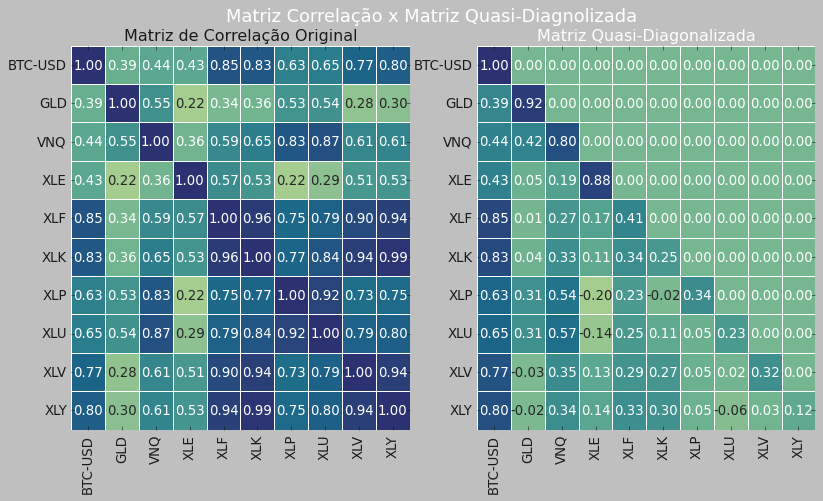

In [3]:
cov_matrix = df_prices_treino.corr()

plt.figure(figsize=(12,6))
plt.suptitle('Matriz Correlação x Matriz Quasi-Diagnolizada',size=16,color='w')
plt.subplot(121)
sns.heatmap(cov_matrix,annot= True, fmt=".2f",linewidths=0.5, cmap='crest',cbar=False)
plt.title('Matriz de Correlação Original')
plt.subplot(122)
sns.heatmap(np.linalg.cholesky(cov_matrix),
            xticklabels=tickers,yticklabels=tickers,annot= True,
            fmt=".2f",linewidths=0.5, cmap='crest',cbar=False)
plt.title('Matriz Quasi-Diagonalizada',color='w')
plt.show()

### Dendrograma
O dendrograma é uma maneira visual de identificar o agrupamento dos ativos de forma ainda mais clara e intuitiva.

<Axes: title={'center': 'Dendrograma do portfólio HRP (Pearson e Ward Linkage)'}>

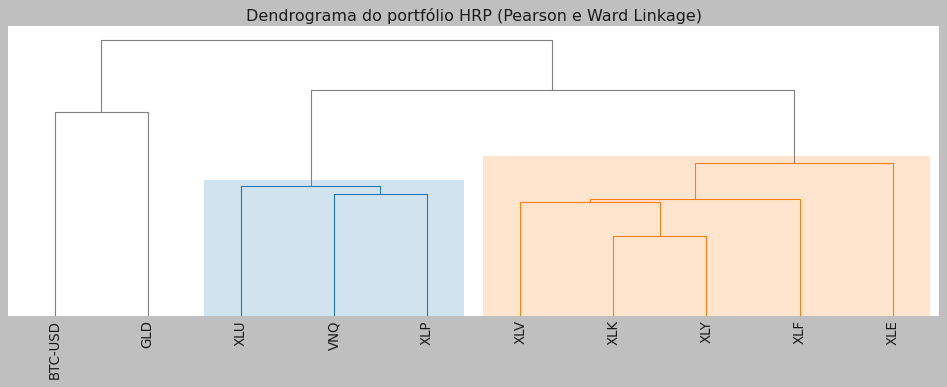

In [4]:
rp.plot_dendrogram(returns=df_returns_treino,
                        codependence='pearson',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        linkage= 'ward',
                        ax=None, title='Dendrograma do portfólio HRP (Pearson e Ward Linkage)')

## Criação dos portfolios

In [5]:
port_sharpe = rp.Portfolio(returns=df_returns_treino)
port_HRP = rp.HCPortfolio(returns=df_returns_treino)
port_sharpe.assets_stats(method_mu="hist", d=0.94)
pesos_sharpe = port_sharpe.optimization(model="Classic", rm="MV", obj="Sharpe",hist=True)
pesos_HRP = port_HRP.optimization(model="HRP", rm="MV",method_cov="shrink", codependence="pearson", rf=0.00,linkage='ward',max_k = 10,leaf_order = True,obj='Sharpe')
pesos = pd.concat([pesos_sharpe,pesos_HRP],axis=1)
pesos.columns = ['Sharpe','HRP']
pesos.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Sharpe,HRP
BTC-USD,16.91%,0.98%
GLD,18.33%,32.44%
VNQ,0.00%,8.62%
XLE,0.00%,2.48%
XLF,0.00%,3.89%
XLK,23.91%,6.49%
XLP,0.00%,13.47%
XLU,22.56%,15.19%
XLV,0.00%,8.22%
XLY,18.29%,8.19%


# Comparação do desempenho das carteiras com os dados de Jan/2019 à Dez/2023
Vamos montar duas carteiras com os ETFs e pesos definidos pelos algoritmos para comparar o retornos, drawdown e suas métricas de retorno ajustado ao risco


### Montando carteiras e méricas

In [6]:
carteiras = pd.DataFrame()
for carteira in pesos.columns:
    carteiras = pd.concat([carteiras,(df_prices_comparacao * pesos[carteira]).sum(axis=1)],axis=1)
carteiras.columns = pesos.columns
carteiras.rename_axis("date",inplace=True)
carteiras.index = pd.to_datetime(carteiras.index)
carteiras_returns = carteiras.pct_change().fillna(0)
carteiras_acum = (((carteiras_returns+1).cumprod())-1)
carteiras_drawdown = qs.stats.to_drawdown_series(carteiras_returns)
metrics = (pd.DataFrame({
        'Volatilidade': qs.stats.volatility(carteiras_returns),
        'Sharpe': qs.stats.sharpe(carteiras_returns),
        'Sortino': qs.stats.sortino(carteiras_returns),
        'Calmar' : qs.stats.calmar(carteiras_returns),
        'Drawdown': qs.stats.max_drawdown(carteiras),
        },index=carteiras.columns))
metrics = metrics.round(3)
print("Retorno acumulado")
carteiras_acum.tail(5).style.format("{:.2%}")

Retorno acumulado


,Sharpe,HRP
date,,
2023-12-22 00:00:00,936.23%,384.77%
2023-12-26 00:00:00,902.11%,372.94%
2023-12-27 00:00:00,923.51%,381.13%
2023-12-28 00:00:00,904.61%,373.97%
2023-12-29 00:00:00,892.31%,369.24%


### Plotando Gráfico de Comparação

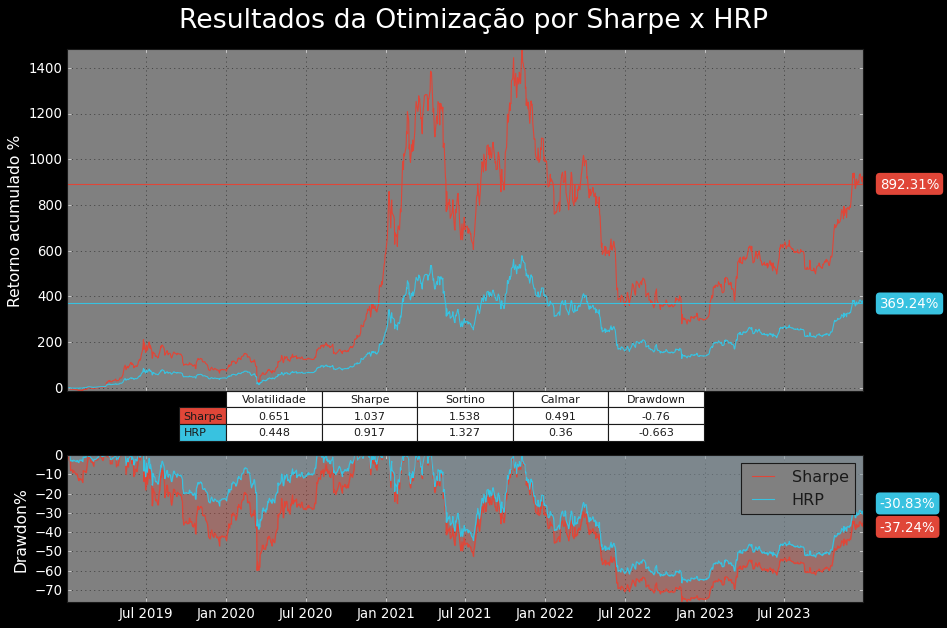

In [7]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'gray'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['axes.axisbelow'] = True
plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [7,3]})
plt.subplot(211)
colors=['#e04638','#38c2e0']

table = plt.table(cellText=metrics.values.tolist(),
                  colLabels=metrics.columns,
                  rowLabels=metrics.index,
                  rowColours=colors,
                  loc='bottom', cellLoc='center')
for key, cell in table.get_celld().items():
    cell.set_width(0.1) 

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)


for i,cart in enumerate(carteiras_acum.columns):
    plt.plot(carteiras_acum.index,carteiras_acum[cart]*100,color=colors[i],label=cart)
    plt.axhline(y=carteiras_acum[cart][-1]*100, color=colors[i], linewidth=1)
    plt.annotate(f'{carteiras_acum[cart][-1]*100:.2f}%', xy=(carteiras_acum.index[-1], carteiras_acum[cart][-1]*100),
                xytext=(15, 0), textcoords='offset points', color='white', backgroundcolor=colors[i],
                ha='left', va='center', bbox=dict(facecolor=colors[i], edgecolor='none', boxstyle='round,pad=0.3'))
plt.ylabel('Retorno acumulado %')
plt.grid()

#___________________________
plt.subplot(212)
for i,cart in enumerate(carteiras_acum.columns):
    plt.plot(carteiras_drawdown.index,carteiras_drawdown[cart]*100,color=colors[i],label=cart)
    plt.fill_between(carteiras_drawdown.index, carteiras_drawdown[cart] * 100, color=colors[i], alpha=0.3)
    
plt.annotate(f'{carteiras_drawdown.iloc[-1,0] * 100:.2f}%', xy=(carteiras_drawdown.index[-1], carteiras_drawdown.iloc[-1,0] * 100),
             xytext=(15, 0), textcoords='offset points', color='white', backgroundcolor=colors[0],
             ha='left', va='center', bbox=dict(facecolor=colors[0], edgecolor='none', boxstyle='round,pad=0.3'))

plt.annotate(f'{carteiras_drawdown.iloc[-1,1] * 100:.2f}%', xy=(carteiras_drawdown.index[-1], carteiras_drawdown.iloc[-1,1] * 100),
             xytext=(15, 10), textcoords='offset points', color='white', backgroundcolor=colors[1],
             ha='left', va='center', bbox=dict(facecolor=colors[1], edgecolor='none', boxstyle='round,pad=0.3'))
plt.ylabel('Drawdon%')
plt.grid()

#____________________________

plt.suptitle('Resultados da Otimização por Sharpe x HRP',color='w',size=24)
plt.subplots_adjust(hspace=0.45)
plt.tight_layout()
plt.legend()
plt.savefig('HRP_Markowitz.png')
plt.show()

# Conclusão
Embora a otimização por **HRP** seja um método mais moderno e apresente maior robustez na seleção dos ativos, o método de **Markowitz** superou o método HRP na maioria dos indicadores de retorno ajustado ao risco. No entanto, seu drawdown e sua volatilidade são maiores que os da otimização por HRP. Um dos fatores para isso é a concentração da carteira **Sharpe** em Bitcoin e em ETFs que apresentaram maior retorno no passado, exatamente um dos efeitos que o método HRP busca evitar.
Além disso, é fundamental analisar cada consideração feita altera os resultados da otimização, como melhores aproximações das matrizes de covarriância ou outros métodos de ligação e clusterização para o método HRP que influênciam nos resultados.

Tmabém é interessante ver que as 2 carteiras bateriam o **S&P500** no período.

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Carteiras otimizadas x S&P500')

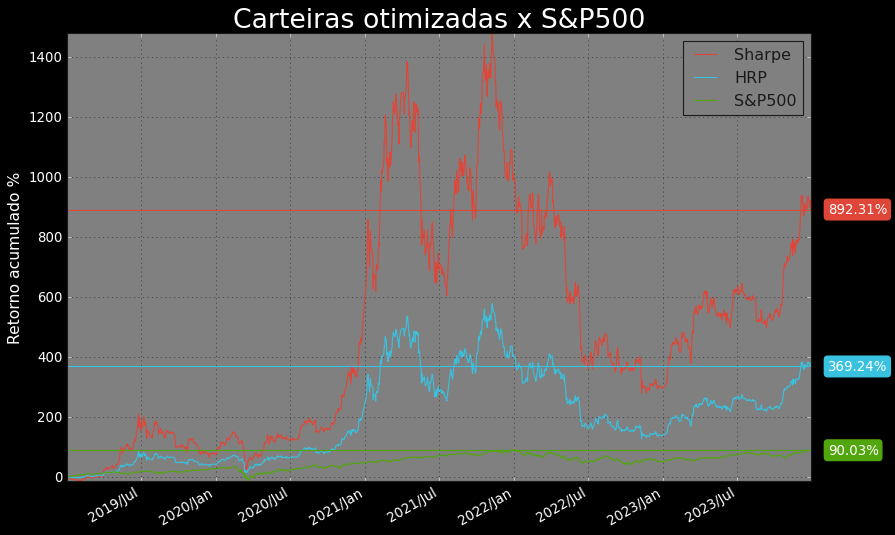

In [8]:
spy = yf.download('^SPX',start=inicio_comparacao,end=fim_comparacao)['Adj Close']
spy_returns = spy.pct_change().fillna(0)
spy_acum = (((spy_returns+1).cumprod())-1)
carteiras_acum['S&P500'] = spy_acum
plt.figure(figsize=(12,8))
colors=['#e04638','#38c2e0','#52a60d']
for i,cart in enumerate(carteiras_acum.columns):
    plt.plot(carteiras_acum.index,carteiras_acum[cart]*100,color=colors[i],label=cart)
    plt.axhline(y=carteiras_acum[cart][-1]*100, color=colors[i], linewidth=1)
    plt.annotate(f'{carteiras_acum[cart][-1]*100:.2f}%', xy=(carteiras_acum.index[-1], carteiras_acum[cart][-1]*100),
                xytext=(15, 0), textcoords='offset points', color='white', backgroundcolor=colors[i],
                ha='left', va='center', bbox=dict(facecolor=colors[i], edgecolor='none', boxstyle='round,pad=0.3'))
plt.ylabel('Retorno acumulado %')
plt.gca().xaxis.set_major_formatter(mdt.DateFormatter('%Y/%b'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid()
plt.title('Carteiras otimizadas x S&P500',size=24)